In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyhdf.SD import SD, SDC

In [3]:
import pandas as pd
import pyproj
from mpl_toolkits.basemap import Basemap

In [209]:
# Fixing figure output for all figures
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['figure.dpi'] = 160
rcParams['savefig.dpi'] = 400
rcParams['text.usetex'] = True

In [4]:
cd /Users/grigsbye/Desktop/School/UCSB/EarthDB/GREENLAND/

/Users/grigsbye/Desktop/School/UCSB/EarthDB/GREENLAND


In [5]:
#mod07_1 = SD('./MOD07_L2.A2013183.1730.006.2013184014917.hdf', SDC.READ)
mod07_1 = SD('./MOD07_L2.A2013199.1730.006.2013203211253.hdf', SDC.READ)
#mod07_3 = SD('./MOD07_L2.A2013215.1730.006.2013216015901.hdf', SDC.READ)
#mod07_4 = SD('./MOD07_L2.A2013231.1730.006.2013232015309.hdf', SDC.READ)

In [6]:
mod07_1.datasets()
for key in mod07_1.datasets(): print key

Water_Vapor_High
Processing_Flag
Total_Ozone
K_Index
Brightness_Temperature
Latitude
Solar_Zenith
Retrieved_Moisture_Profile
Guess_Moisture_Profile
Sensor_Azimuth
Retrieved_Temperature_Profile
Scan_Start_Time
Lifted_Index
Water_Vapor_Direct
Total_Totals
Retrieved_WV_Mixing_Ratio_Profile
Quality_Assurance_Infrared
Tropopause_Height
Surface_Elevation
Skin_Temperature
Water_Vapor_Low
Longitude
Guess_Temperature_Profile
Water_Vapor
Sensor_Zenith
Solar_Azimuth
Quality_Assurance
Retrieved_Height_Profile
Cloud_Mask
Surface_Pressure


In [7]:
lat, lon = mod07_1.select('Latitude'), mod07_1.select('Longitude')

In [8]:
# Stolen / modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file

In [9]:
from osgeo import osr, gdal

In [10]:
# get the existing coordinate system
ds = gdal.Open('../LC80230062013199LGN00_B2.TIF')
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

0

In [11]:
ds.GetProjectionRef()

'PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32621"]]'

In [12]:
# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

0

In [13]:
# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 



In [14]:
gt

(327285.0, 30.0, 0.0, 8560815.0, 0.0, -30.0)

In [15]:
old_cs.ExportToProj4()

'+proj=utm +zone=21 +datum=WGS84 +units=m +no_defs '

In [16]:
p2 = pyproj.Proj(old_cs.ExportToProj4())

In [17]:
transform.TransformPoint(minx,miny),p2(minx,miny,inverse=True) # Close enough...

((-62.83540620266592, 74.60017067588079, 0.0),
 (-62.83540620266587, 74.60017067588073))

In [18]:
len(r_[327315.000:600030.000:300]),len(r_[8560785.000:8287470.000:-300]) # 15 meter offset for center of pixels

(910, 912)

In [19]:
x1, y1 = meshgrid(r_[327315.000:600030.000:300],r_[8560785.000:8287470.000:-300]) # offset by 1 meter to preserve shape
LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
LScoords

array([[  327315.,  8560785.],
       [  327615.,  8560785.],
       [  327915.,  8560785.],
       ..., 
       [  599415.,  8287485.],
       [  599715.,  8287485.],
       [  600015.,  8287485.]])

In [20]:
xs, ys = p2(LScoords[:,0], LScoords[:,1],inverse=True, radians=True)
grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)

In [21]:
len(grid_coords), 910*912

(829920, 829920)

In [22]:
grid_coords  # radian coordinates of landsat image

array([[ 1.34450582, -1.11543672],
       [ 1.34451131, -1.11522918],
       [ 1.3445168 , -1.11502162],
       ..., 
       [ 1.30290567, -0.93608331],
       [ 1.30290301, -0.9359064 ],
       [ 1.30290034, -0.9357295 ]])

In [23]:
shape(lat[:].ravel())

(109620,)

In [24]:
#MODIS_coords = np.vstack([lats.ravel(),longs.ravel()]).T
#MODIS_coords *= np.pi / 180. # to radians
#MODIS_coords, len(MODIS_coords)

In [25]:
MODIS_coords = np.vstack([lat[:].ravel(),lon[:].ravel()]).T
MODIS_coords *= np.pi / 180. # to radians
MODIS_coords, len(MODIS_coords)

(array([[ 1.48374474, -2.33551884],
        [ 1.48542881, -2.29672432],
        [ 1.48692477, -2.25796318],
        ..., 
        [ 1.06750727, -1.18645382],
        [ 1.06537986, -1.18087912],
        [ 1.0631597 , -1.17514324]], dtype=float32), 109620)

In [26]:
from sklearn.neighbors import BallTree, ball_tree

In [27]:
MOD_Ball = BallTree(MODIS_coords,metric='haversine')

In [28]:
#LS_Ball = BallTree(grid_coords,metric='haversine')

In [34]:
%%prun
tst1, tst2 = MOD_Ball.query(grid_coords[0:5000],dualtree=True, breadth_first=True)
tst1, tst2

In [29]:
distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)

In [30]:
OZ = mod07_1.select('Total_Ozone')

In [31]:
lat, lon = mod07_1.select('Latitude'), mod07_1.select('Longitude')

In [32]:
WV = mod07_1.select('Water_Vapor')

In [33]:
WV.attributes()

{'Cell_Across_Swath_Sampling': [3, 1348, 5],
 'Cell_Along_Swath_Sampling': [3, 2028, 5],
 'Geolocation_Pointer': 'Internal geolocation arrays',
 'Parameter_Type': 'Output',
 '_FillValue': -9999,
 'add_offset': 0.0,
 'long_name': 'Total Column Precipitable Water Vapor - IR Retrieval',
 'scale_factor': 0.0010000000474974513,
 'units': 'cm',
 'valid_range': [0, 20000]}

In [34]:
shape(lat[:]),shape(lon[:]),shape(OZ[:])

/usr/local/lib/python2.7/site-packages/pyhdf-0.8.3-py2.7-macosx-10.9-x86_64.egg/pyhdf/SD.py:1876: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/site-packages/pyhdf-0.8.3-py2.7-macosx-10.9-x86_64.egg/pyhdf/SD.py:1876: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


((406, 270), (406, 270), (406, 270))

(406, 270)

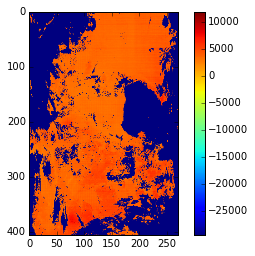

In [35]:
imshow(OZ[:])
colorbar()
shape((OZ[:]))

(406, 270)

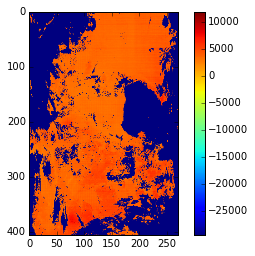

In [36]:
imshow(OZ[:])
colorbar()
shape((OZ[:]))

In [37]:
OZ.attributes()

{'Cell_Across_Swath_Sampling': [3, 1348, 5],
 'Cell_Along_Swath_Sampling': [3, 2028, 5],
 'Geolocation_Pointer': 'Internal geolocation arrays',
 'Parameter_Type': 'Output',
 '_FillValue': -32768,
 'add_offset': 0.0,
 'long_name': 'Total Ozone Burden',
 'scale_factor': 0.10000000149011612,
 'units': 'Dobson',
 'valid_range': [0, 5000]}

<matplotlib.colorbar.Colorbar instance at 0x14247a5f0>

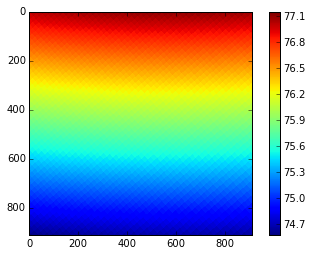

In [74]:
imshow(reshape(np.array(lat[:].ravel())[indiciesMOD],(912,910)))
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x1432eaea8>

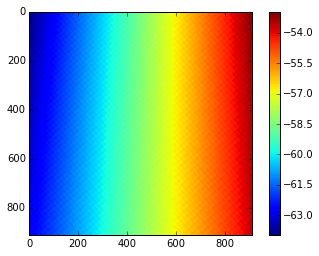

In [75]:
imshow(reshape(np.array(lon[:].ravel())[indiciesMOD],(912,910)))
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x124fed290>

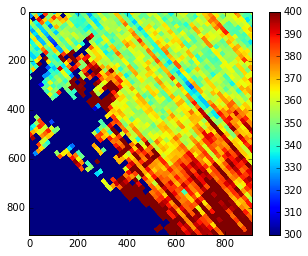

In [38]:
imshow(reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910)),vmax=400,vmin=300)
colorbar()

In [183]:
#m = Basemap(projection='ortho',lat_0=50,lon_0=300,resolution='l')
m = Basemap(projection='laea',lat_0=50,lon_0=300,resolution='h',area_thresh = 0.1,
#m = Basemap(projection='npstere',lat_0=50,boundinglat=70,lon_0=300,resolution='l',
#            llcrnrlon=-66,llcrnrlat=74.,urcrnrlon=-51,urcrnrlat=77.5)
            llcrnrlon=-70,llcrnrlat=74.,urcrnrlon=-31,urcrnrlat=80)
y_ = reshape(np.array(lat[:].ravel())[indiciesMOD],(912,910))
x_ = reshape(np.array(lon[:].ravel())[indiciesMOD],(912,910))
x, y = m(x_, y_)
#x, y = m(lon[:].ravel(), lat[:].ravel())


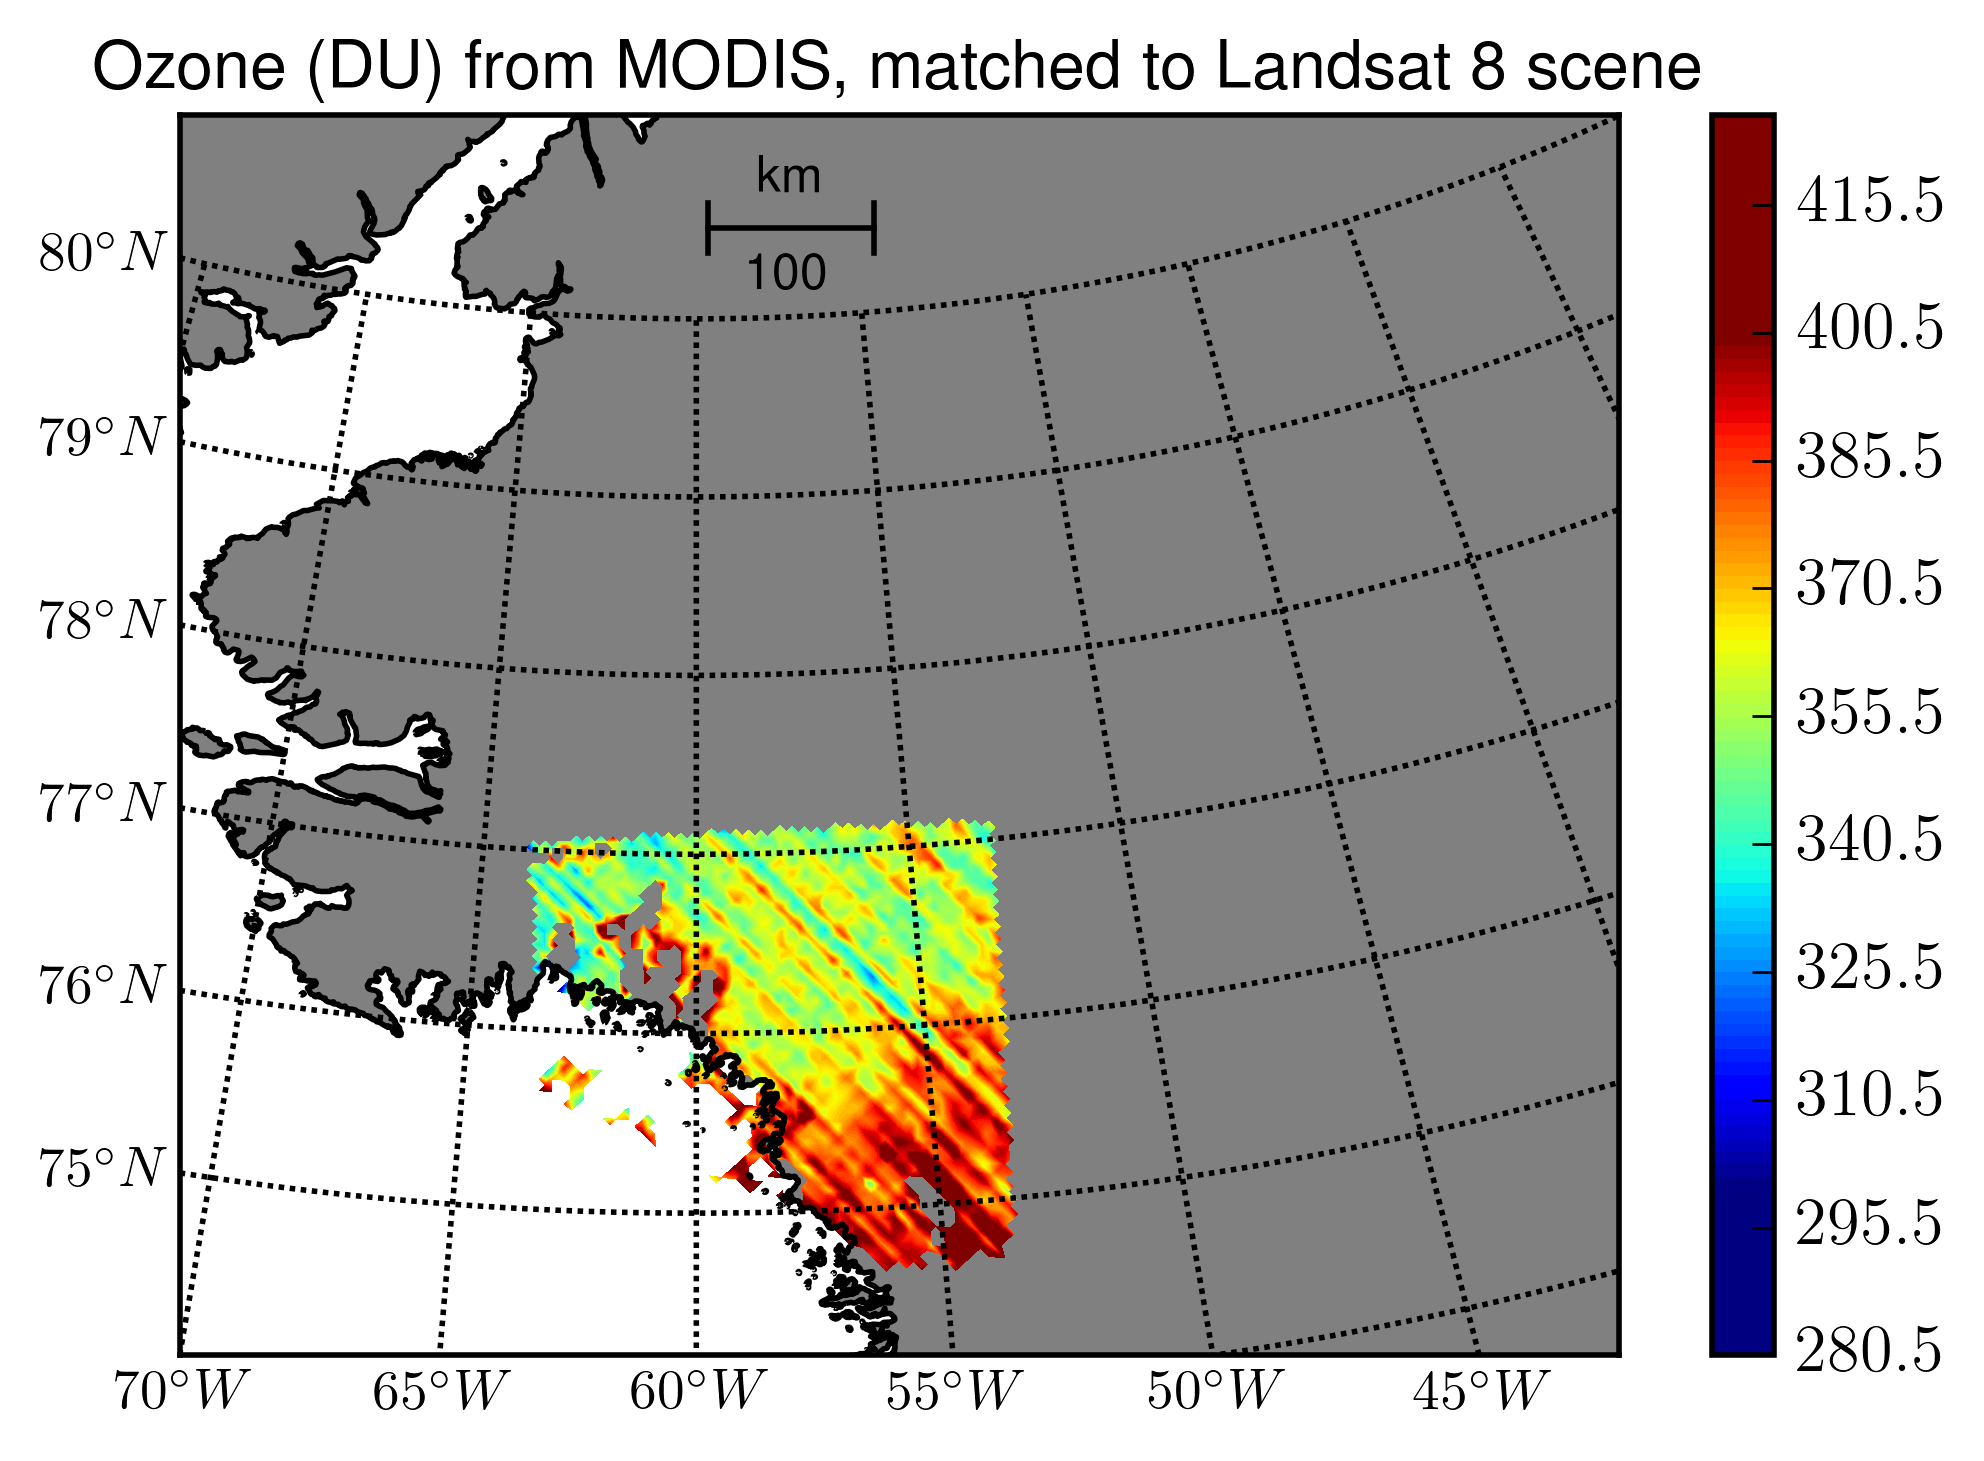

In [210]:
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=0)
m.drawparallels(np.arange(-80.,81.,1.),labels=[True,False,True,False])
m.drawmeridians(np.arange(-180.,181.,5.),labels=[False,False,False,True])
m.drawmapboundary(fill_color='white')
m.contourf(x,y,data1,100,vmax=400,vmin=300)
m.drawmapscale(-57,80.5,0,0,100)
title(r'Ozone (DU) from MODIS, matched to Landsat 8 scene')
colorbar()
savefig('/Users/grigsbye/Desktop/Ozone_NW_Greenland.jpeg')

In [145]:
dataWV = reshape(np.array(WV[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910))
dataWV[dataWV < 0] = np.nan

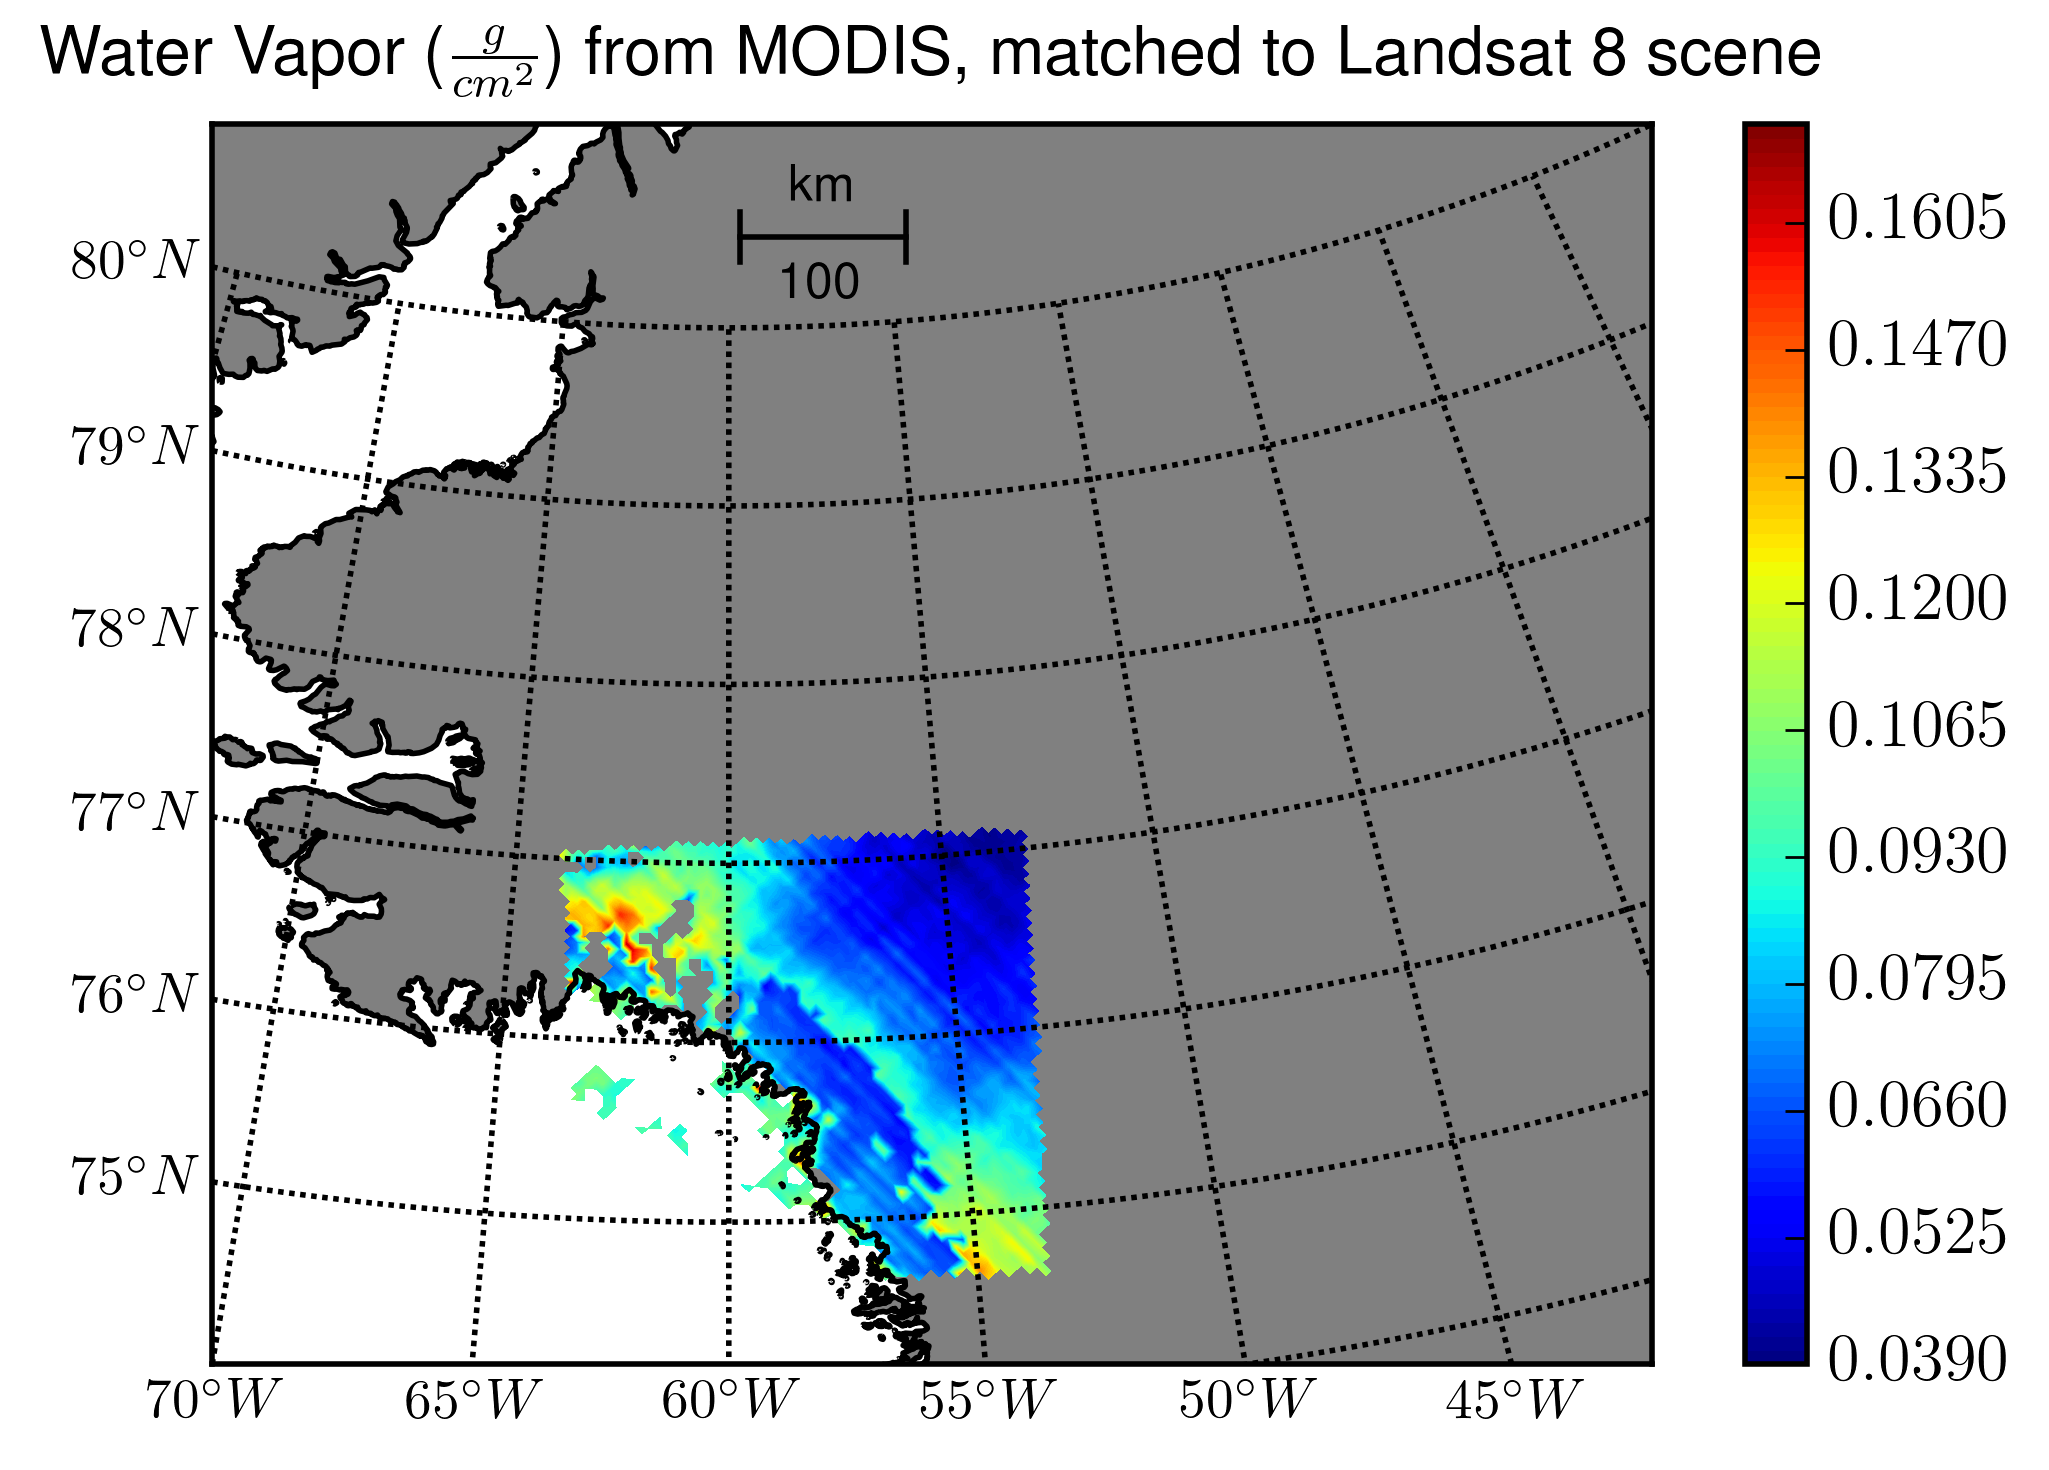

In [211]:
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=0)
m.drawparallels(np.arange(-80.,81.,1.),labels=[True,False,True,False])
m.drawmeridians(np.arange(-180.,181.,5.),labels=[False,False,False,True])
m.drawmapboundary(fill_color='white')
m.contourf(x,y,dataWV*0.0010000000474974513,100)
m.drawmapscale(-57,80.5,0,0,100)
colorbar()
title(r'Water Vapor ($\frac{g}{cm^2}$) from MODIS, matched to Landsat 8 scene')
savefig('/Users/grigsbye/Desktop/WaterVapor_NW_Greenland.jpeg')

In [163]:
#m = Basemap(projection='ortho',lat_0=50,lon_0=300,resolution='l')
#m = Basemap(projection='laea',lat_0=50,lon_0=300,resolution='h',
m = Basemap(projection='npstere',lat_0=50,boundinglat=60,lon_0=300,resolution='l',
#            llcrnrlon=-66,llcrnrlat=74.,urcrnrlon=-51,urcrnrlat=77.5)
            llcrnrlon=-70,llcrnrlat=70.,urcrnrlon=-21,urcrnrlat=80)
y_ = reshape(np.array(lat[:].ravel())[indiciesMOD],(912,910))
x_ = reshape(np.array(lon[:].ravel())[indiciesMOD],(912,910))
x, y = m(x_, y_)
#x, y = m(lon[:].ravel(), lat[:].ravel())
#x, y = m(meshgrid(lon[:].ravel(), lat[:].ravel()))

In [204]:
data1 = reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910))
dataB = data1[:]*0
data1[data1 < 280] = np.nan
data1[data1 > 425] = np.nan

<matplotlib.colorbar.Colorbar instance at 0x179b5cb00>

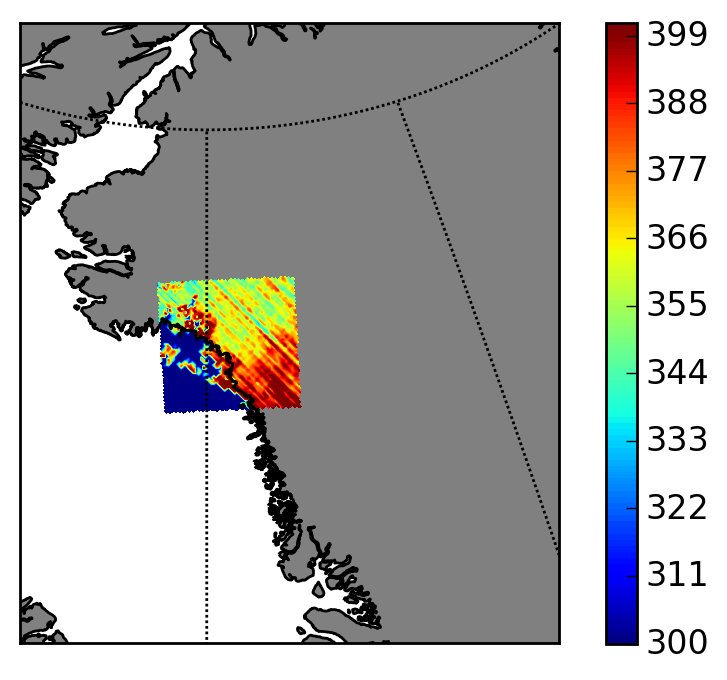

In [131]:
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=0)
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
m.contourf(x,y,data1,100,vmax=400,vmin=300)
colorbar()

<matplotlib.contour.QuadContourSet instance at 0x19faad998>

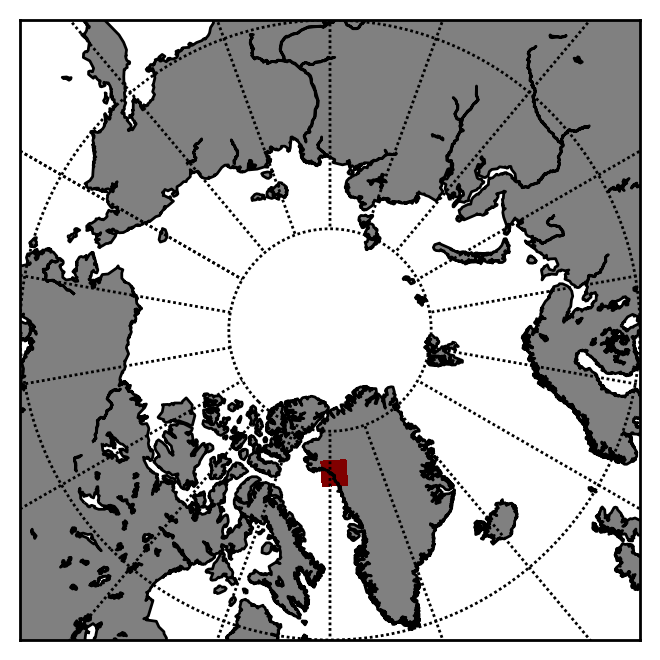

In [172]:
m.drawcoastlines()
m.fillcontinents(color='gray',zorder=0)
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
m.contourf(x,y,dataB,100,vmin=-400)
#colorbar()

In [57]:
OZ[:]

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ..., 
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

In [67]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import percentile_filter

In [66]:
from skimage import restoration
from scipy import stats

In [ ]:
imshow(percentile_filter(
reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910)),
percentile=10,size=(912,910))
,vmax=400,vmin=300)
colorbar()

In [39]:
imshow(reshape(np.array(km['WV'])[indiciesMOD],(9111,9091))) # Overkill... a 912 by 910 array is way faster, and looks the same
colorbar()

NameError: name 'km' is not defined

<matplotlib.colorbar.Colorbar instance at 0x204a85a8>

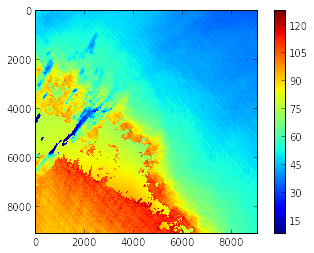

In [31]:
imshow(reshape(np.array(km['WV'])[indiciesMOD],(9111,9091))) # Overkill... a 912 by 910 array is way faster, and looks the same
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x132125710>

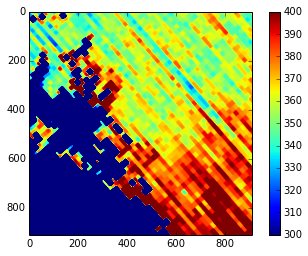

In [62]:
imshow(gaussian_filter(
reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910)),
2)
,vmax=400,vmin=300)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x12b94fbd8>

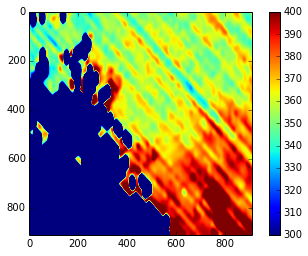

In [56]:
imshow(gaussian_filter(
reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910)),
(10,2))
,vmax=400,vmin=300)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x12a4bd638>

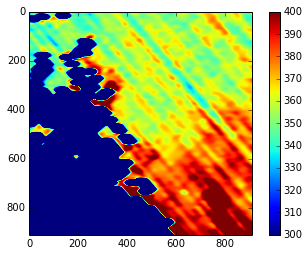

In [55]:
imshow(gaussian_filter(
reshape(np.array(OZ[:].ravel())[indiciesMOD]*0.10000000149011612,(912,910)),
(2,10))
,vmax=400,vmin=300)
colorbar()

In [57]:
imshow(reshape(np.array(km['WV'])[indiciesMOD],(9111,9091))) # Overkill... a 912 by 910 array is way faster, and looks the same
colorbar()

NameError: name 'km' is not defined

<matplotlib.colorbar.Colorbar instance at 0x14051db48>

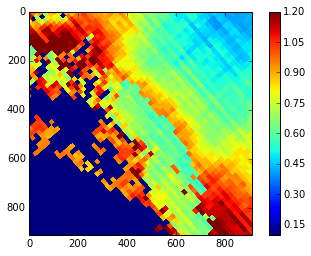

In [95]:
imshow(reshape(np.array(WV[:].ravel())[indiciesMOD]*0.0010000000474974513,(912,910)),vmax=1.2,vmin=.1)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x13f059908>

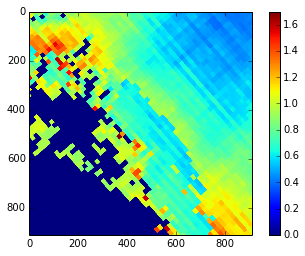

In [94]:
imshow(reshape(np.array(WV[:].ravel())[indiciesMOD]*0.0010000000474974513,(912,910)),vmin=0)#,vmax=1.2,vmin=.1)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x137d23d88>

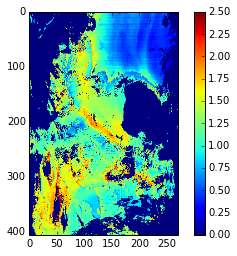

In [81]:
imshow(WV[:]*0.0010000000474974513,vmin=0,vmax=2.5)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x13893dbd8>

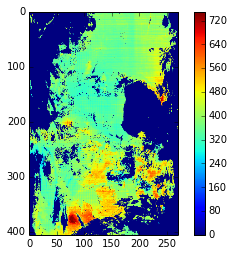

In [84]:
imshow(OZ[:]*0.10000000149011612,vmin=0,vmax=750)
colorbar()

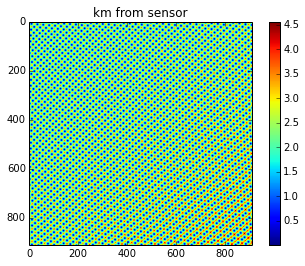

In [37]:
imshow(reshape(distanceMOD*6371,(912,910)))
colorbar()
title('km from sensor')

In [45]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
